## Chromatophores - Load processed data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import napari
%config InlineBackend.figure_format = 'retina'

In [3]:
from process_video import load_video_zarr



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	darwin 
python version: 	3.11.11 
torch version:  	2.6.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [4]:
video_path = '/Users/horst/Library/CloudStorage/GoogleDrive-hobenhaus@gmail.com/My Drive/OCTRON/Project folders - in progress/chromatophores/original videos/resized/0N3A1505_resized.mp4'

### Load results back in 

In [5]:
zarr_path, parquet_path, video, mask_zarr = load_video_zarr(Path(video_path),
                                                            remove_previous_zarr=False
                                                            )
export_path = parquet_path.parent
num_frames = video.shape[0]
image_height = video.shape[1]
image_width = video.shape[2]

chroma_data = pd.read_parquet(parquet_path)
print(chroma_data.columns)

Loading existing zarr mask file
Existing keys in zarr archive: ['masks']
Zarr store info:
Type               : Array
Zarr format        : 3
Data type          : DataType.int32
Shape              : (12830, 720, 1364)
Chunk shape        : (250, 720, 1364)
Order              : C
Read-only          : False
Store type         : LocalStore
Filters            : ()
Serializer         : BytesCodec(endian=<Endian.little: 'little'>)
Compressors        : (ZstdCodec(level=0, checksum=False),)
No. bytes          : 50400345600 (46.9G)
Index(['label', 'area', 'area_bbox', 'area_convex', 'centroid-0', 'centroid-1',
       'orientation', 'eccentricity', 'solidity', 'extent',
       'major_axis_length', 'minor_axis_length', 'corner_top_left_mean_l',
       'corner_top_right_mean_l', 'corner_bottom_left_mean_l',
       'corner_bottom_right_mean_l', 'mean_l', 'mean_a', 'mean_b', 'mean_hues',
       'mean_sats', 'mean_vals', 'frame', 'region_id', 'centroid_dist'],
      dtype='object')


### Interpolate over missing data

In [6]:
import warnings
# Suppress the DeprecationWarning for groupby-apply on grouping columns
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Interpolate numerical columns in chroma_data per region_id, both forward and backward
chroma_data = chroma_data.groupby('region_id').apply(
    lambda group: group.interpolate(method='linear', limit_direction='both', axis=0)
).reset_index(drop=True)


In [7]:
chroma_ids = np.unique(chroma_data.region_id)
chroma_frames = np.unique(chroma_data.frame)
print(f'{len(chroma_ids)} chromatophores found over {len(chroma_frames)} frames')

891 chromatophores found over 151 frames


### Plot example frame

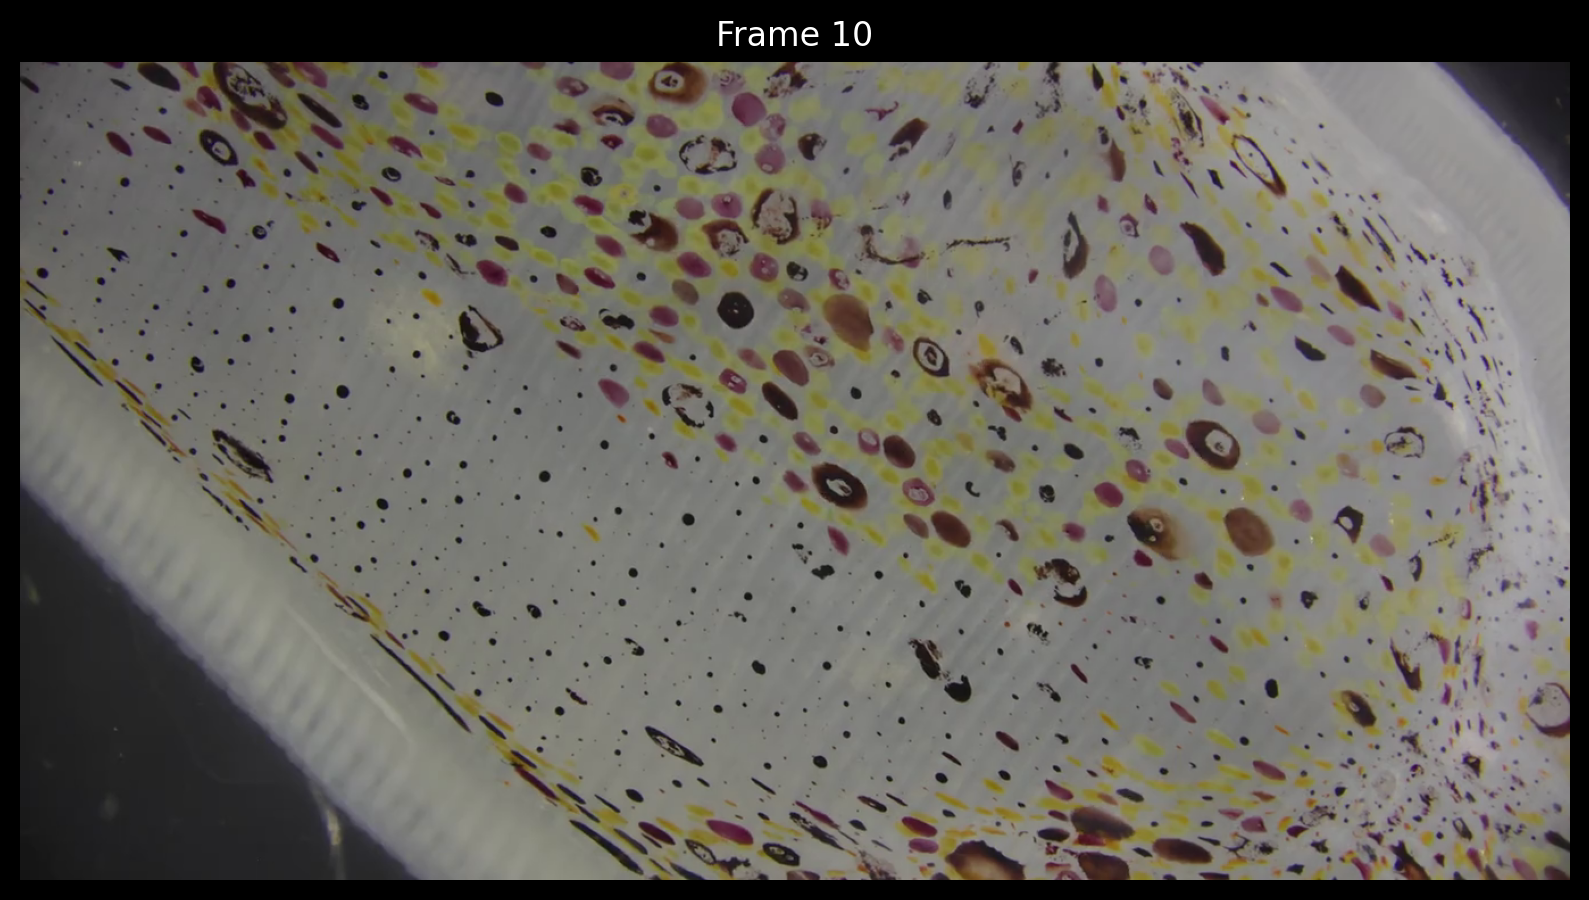

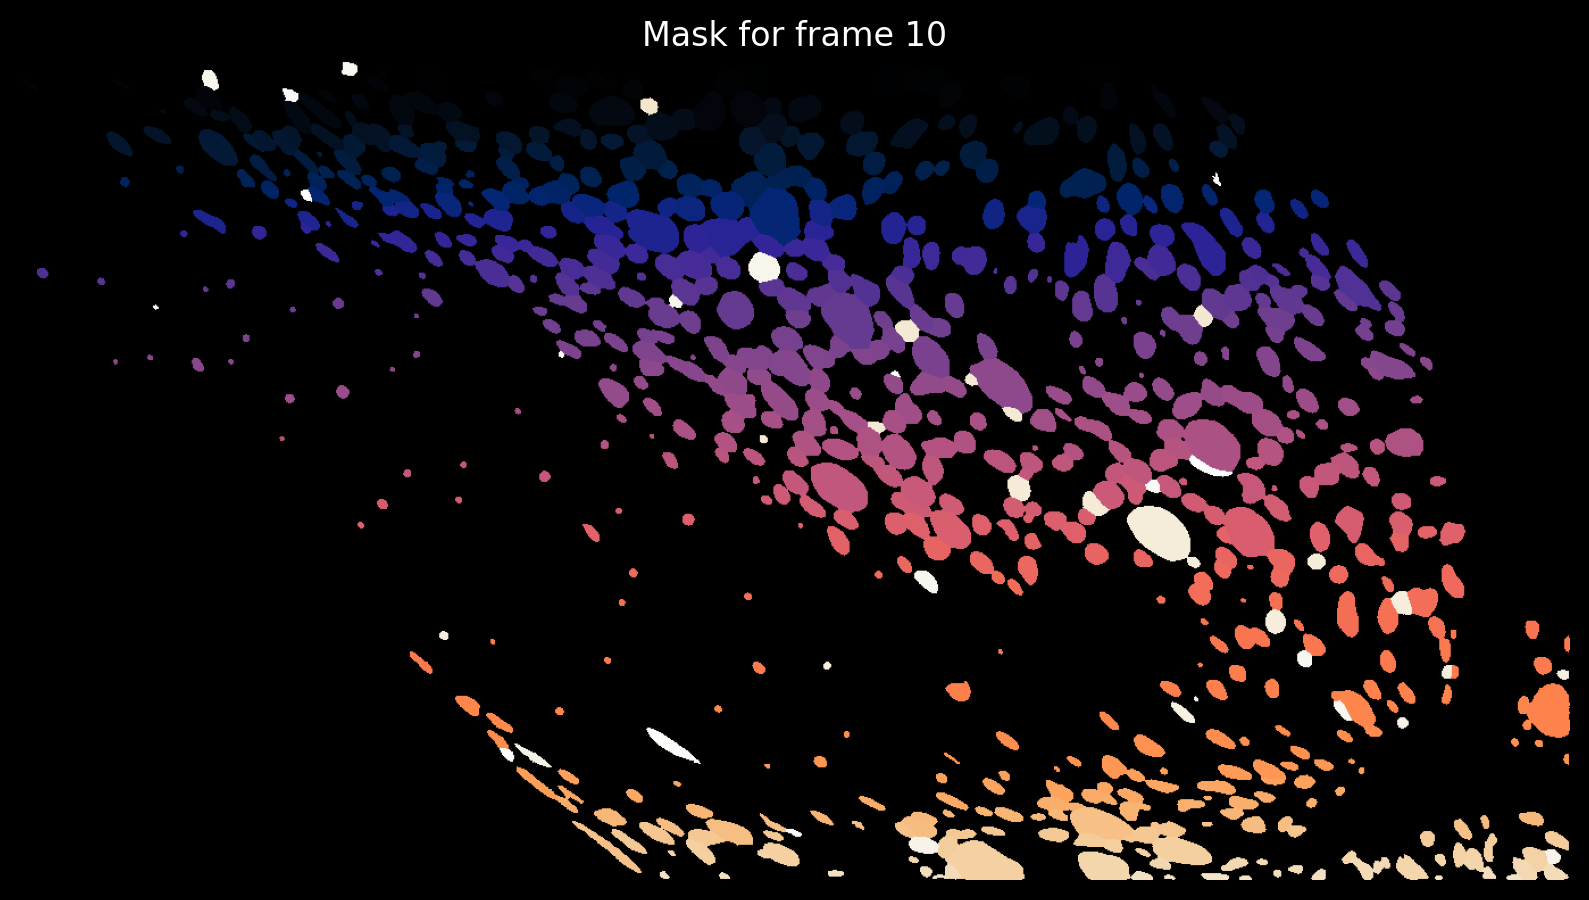

In [8]:
frame_index = 10
mask_zarr[frame_index]


plt.figure(figsize=(10, 7))
plt.imshow(video[frame_index])
plt.title(f'Frame {frame_index}')
plt.axis('off')

plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(mask_zarr[frame_index], cmap='cmr.torch')
plt.title(f'Mask for frame {frame_index}')
plt.axis('off')
plt.show()

### Plot area over time for some examples

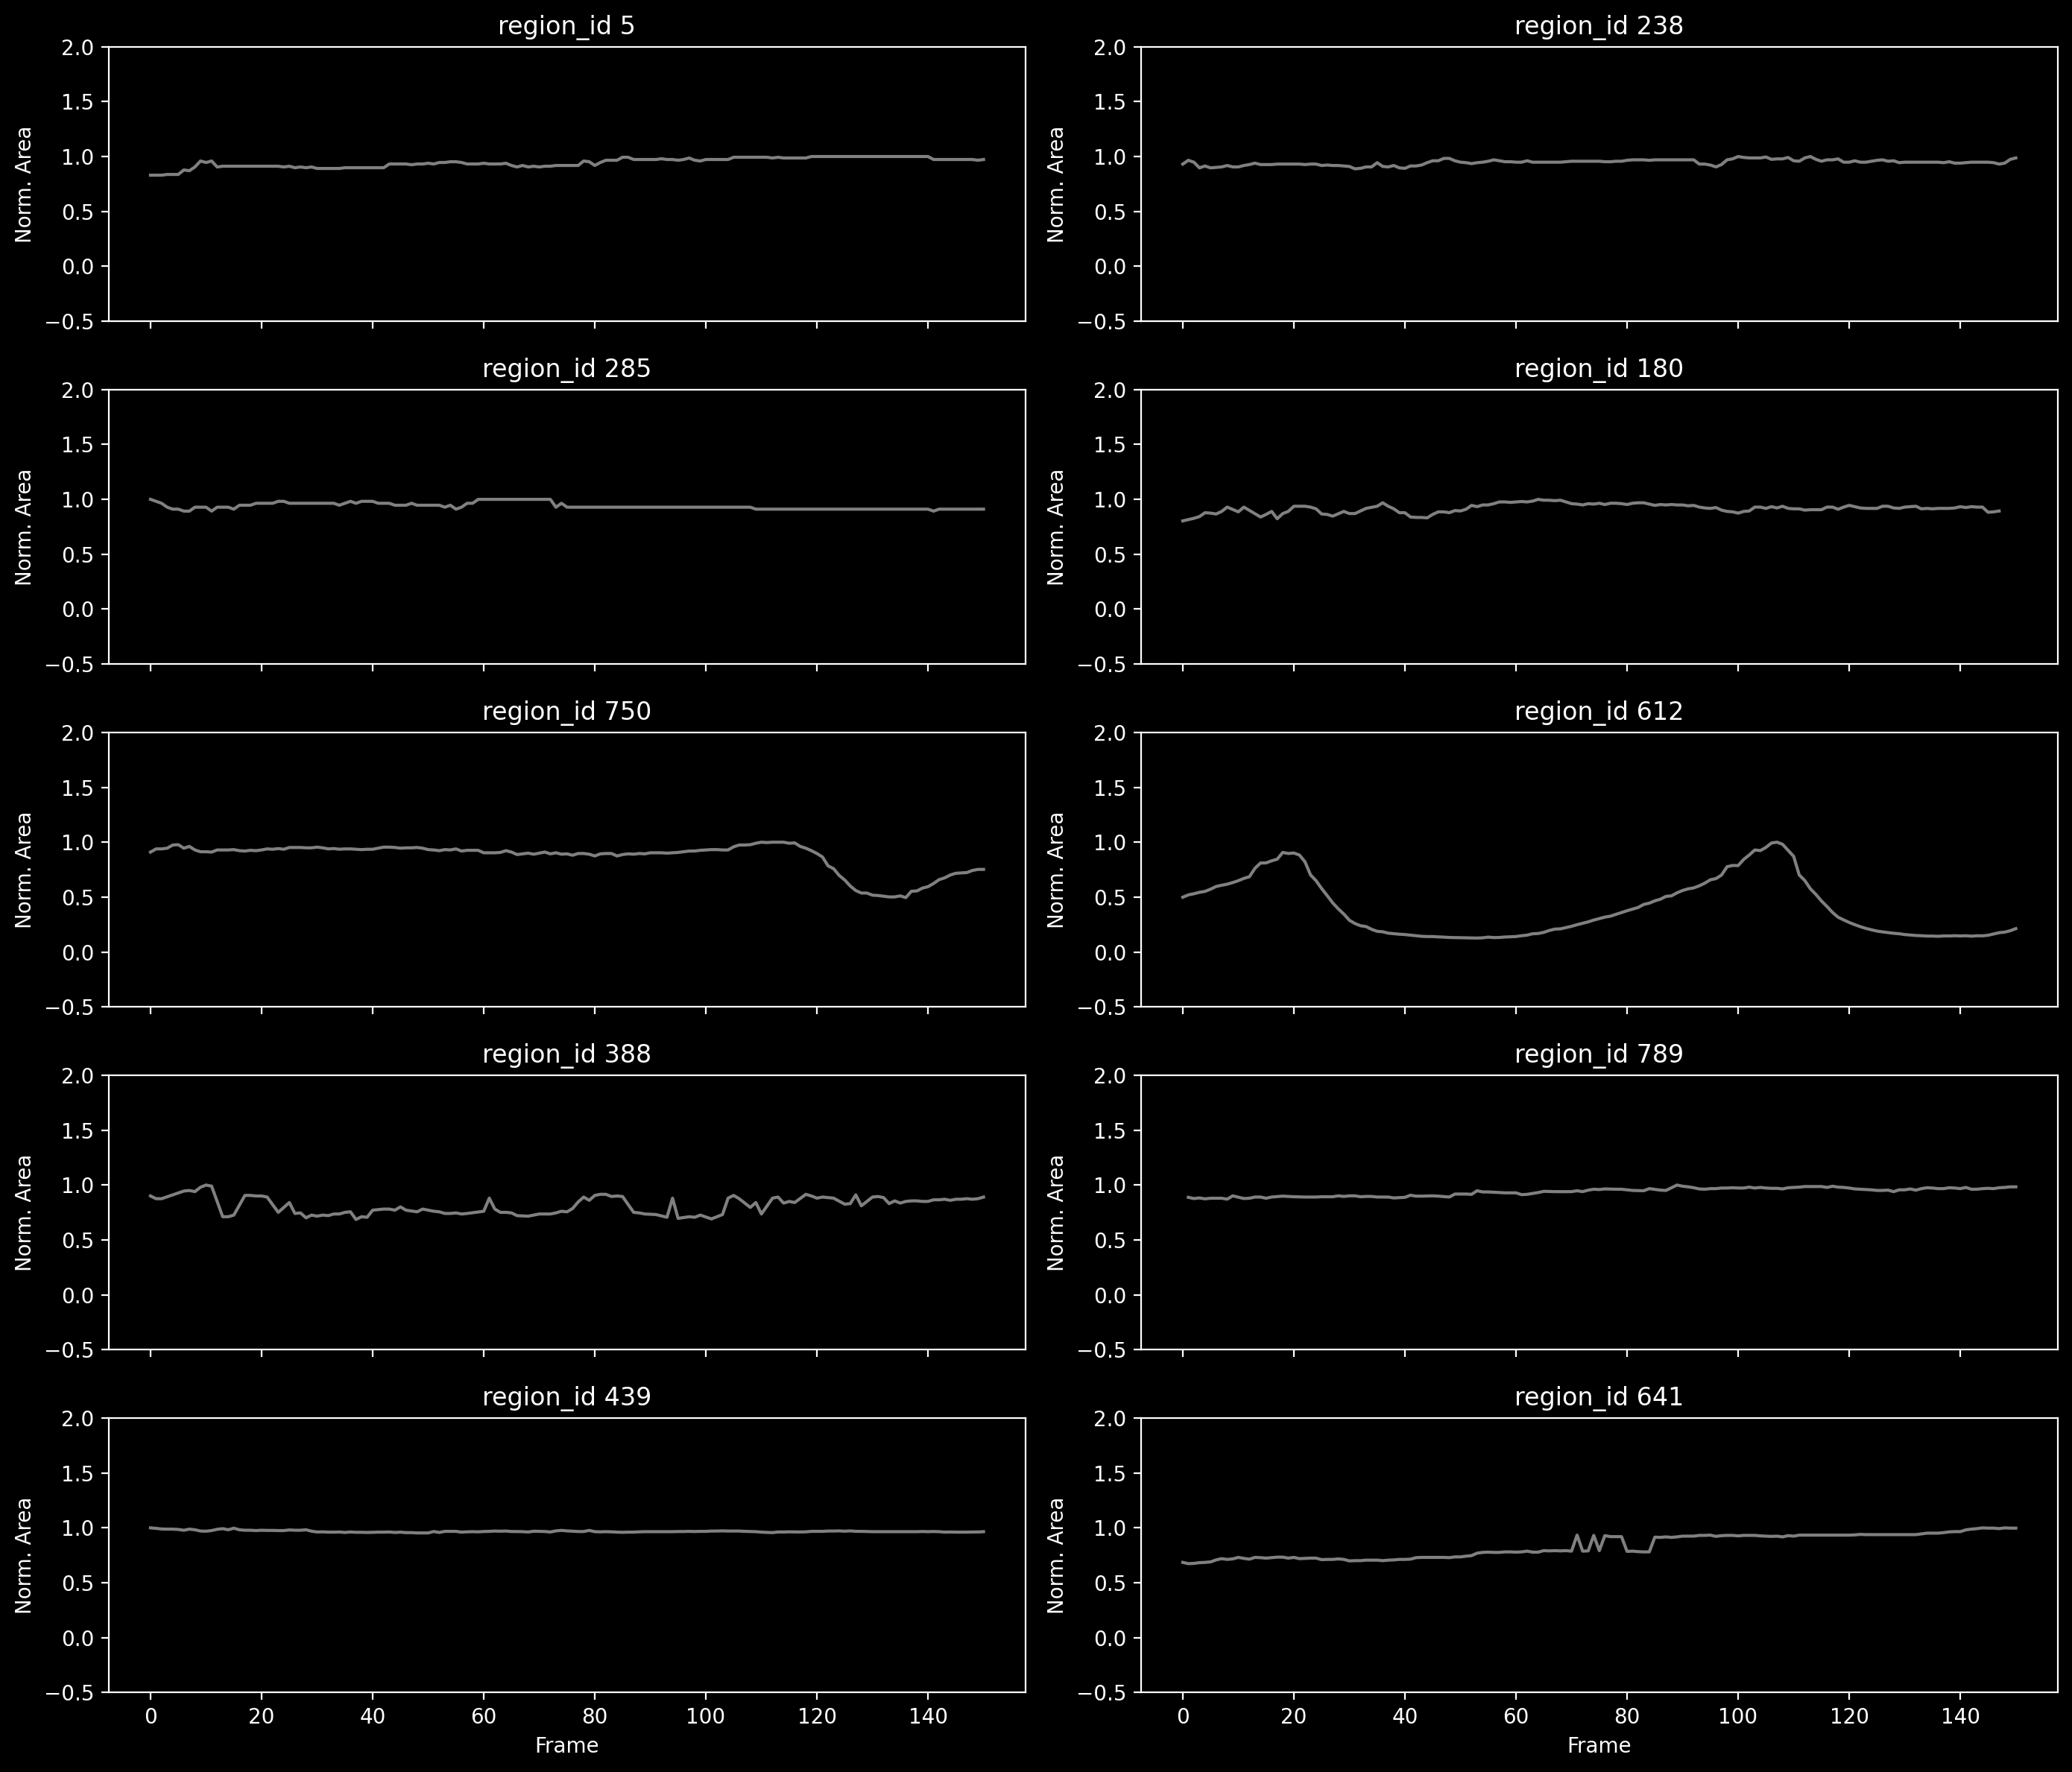

In [40]:
# Plot area over frame for 10 random chroma_ids, each on a separate axis
sample_ids = np.random.choice(chroma_ids, size=10, replace=False)

fig, axes = plt.subplots(5, 2, figsize=(14, 12), sharex=True)
axes = axes.flatten()

for ax, region_id in zip(axes, sample_ids):
    subset = chroma_data[chroma_data['region_id'] == region_id]
    area = subset['area']
    # normalize area 
    area /= np.nanmax(area)
    ax.plot(subset['frame'], subset['area'], color='grey')
    ax.set_title(f'region_id {region_id}')
    ax.set_ylabel('Norm. Area')
    ax.set_ylim(-.5,np.nanmax(area)*2)
    ax.grid(False)

axes[-1].set_xlabel('Frame')
axes[-2].set_xlabel('Frame')
plt.tight_layout()
plt.show()


### When did the laser pulses occurr? 

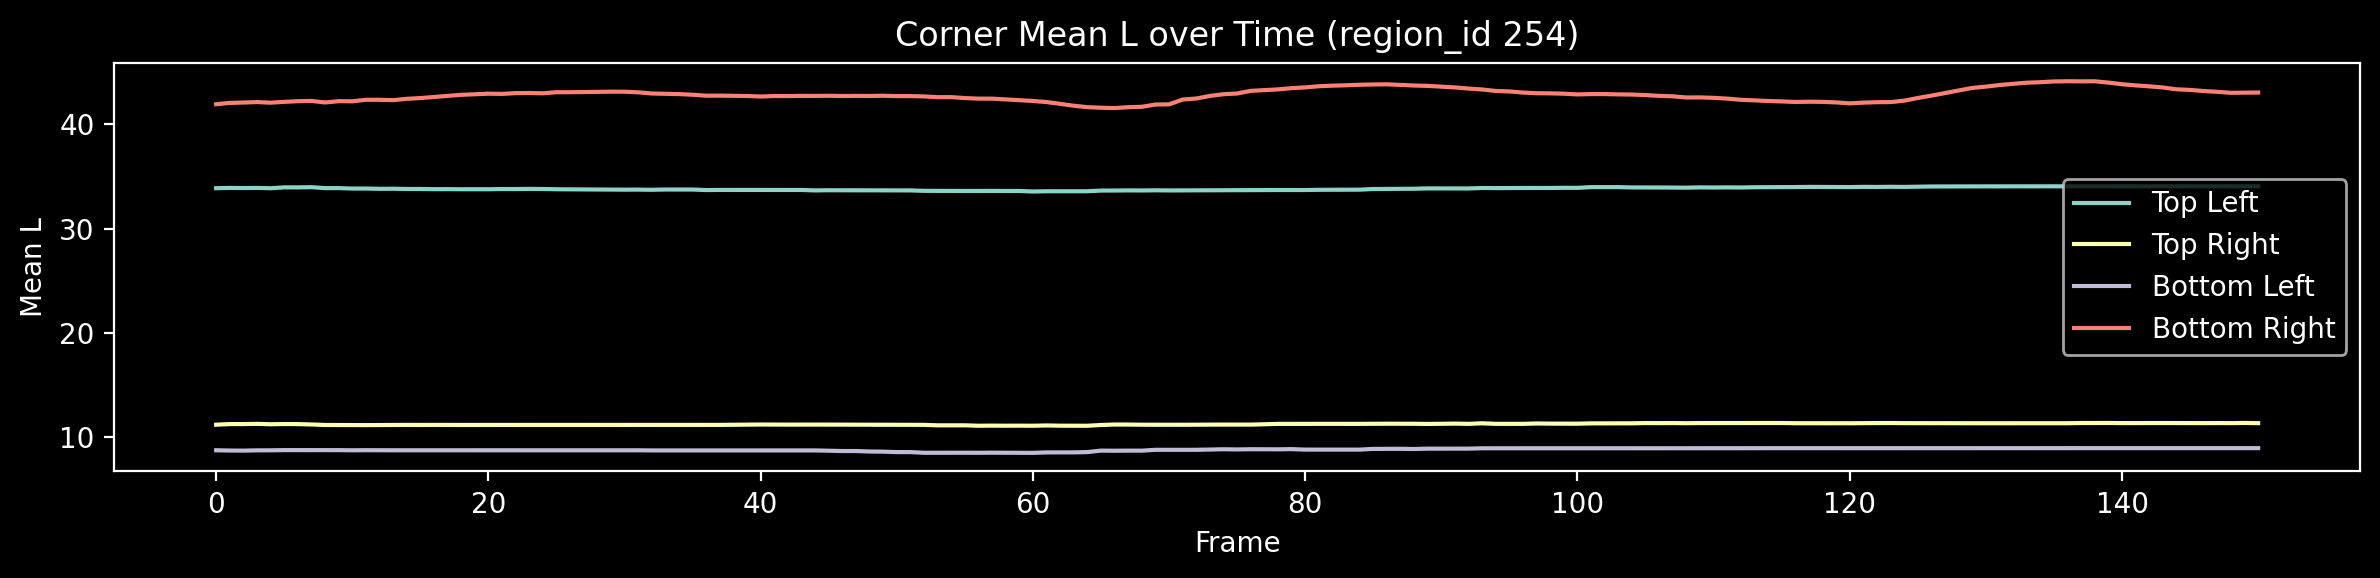

In [10]:
plt.figure(figsize=(12, 3))
plt.plot(subset['frame'], subset['corner_top_left_mean_l'], label='Top Left')
plt.plot(subset['frame'], subset['corner_top_right_mean_l'], label='Top Right')
plt.plot(subset['frame'], subset['corner_bottom_left_mean_l'], label='Bottom Left')
plt.plot(subset['frame'], subset['corner_bottom_right_mean_l'], label='Bottom Right')
plt.xlabel('Frame')
plt.ylabel('Mean L')
plt.title(f'Corner Mean L over Time (region_id {subset.region_id.iloc[0]})')
plt.legend()
plt.tight_layout()
plt.show()

### Cluster chromatophores by spectral content (kmeans with n=3)

In [11]:
from sklearn.cluster import KMeans
region_avg = chroma_data.groupby('region_id').mean(numeric_only=True)

# Use LAB and HSV values to cluster 
cluster_n = 3
sub_dataframe = region_avg[['mean_a','mean_b', 'mean_l', 'mean_hues', 'mean_vals', 'mean_sats']].values
kmeans = KMeans(n_clusters=cluster_n, random_state=0, n_init=500, max_iter=5_000)
region_avg['kmeans_label'] = kmeans.fit_predict(sub_dataframe)
chroma_data = chroma_data.merge(region_avg['kmeans_label'], left_on='region_id', right_index=True, how='left')

In [12]:
chroma_data[chroma_data.region_id==10]

,label,area,area_bbox,area_convex,centroid-0,centroid-1,orientation,eccentricity,solidity,extent,...,mean_l,mean_a,mean_b,mean_hues,mean_sats,mean_vals,frame,region_id,centroid_dist,kmeans_label
1501,11,135.0,189.0,146.0,2.429630,736.666667,1.561225,0.965761,0.924658,0.714286,...,53.191912,-5.566046,20.500249,0.158146,0.301131,0.513551,0,10,0.025126,1
1502,11,137.0,189.0,146.0,2.423358,736.642336,1.566908,0.965776,0.938356,0.724868,...,53.184522,-5.545369,20.431179,0.157962,0.300263,0.513496,1,10,0.025126,1
1503,11,137.0,189.0,146.0,2.423358,736.642336,1.566908,0.965776,0.938356,0.724868,...,53.184522,-5.545369,20.431179,0.157962,0.300263,0.513496,2,10,0.012563,1
1504,11,138.0,189.0,148.0,2.405797,736.724638,-1.569820,0.966004,0.932432,0.730159,...,53.188655,-5.555051,20.418905,0.158094,0.300023,0.513498,3,10,0.078583,1
1505,11,138.0,189.0,148.0,2.405797,736.724638,-1.569820,0.966004,0.932432,0.730159,...,53.188655,-5.555051,20.418905,0.158094,0.300023,0.513498,4,10,0.039291,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,12,171.0,224.0,181.0,2.830409,737.309942,-1.566442,0.958786,0.944751,0.763393,...,53.313760,-5.164370,21.103631,0.153486,0.312457,0.517555,146,10,0.000135,1
1648,12,171.0,224.0,181.0,2.830409,737.309942,-1.566442,0.958786,0.944751,0.763393,...,53.313760,-5.164370,21.103631,0.153486,0.312457,0.517555,147,10,0.000068,1
1649,12,171.0,224.0,181.0,2.830409,737.309942,-1.566442,0.958786,0.944751,0.763393,...,53.313760,-5.164370,21.103631,0.153486,0.312457,0.517555,148,10,0.000034,1
1650,12,172.0,224.0,181.0,2.854651,737.325581,-1.567866,0.957756,0.950276,0.767857,...,53.303423,-5.144155,21.048610,0.153369,0.311776,0.517465,149,10,0.028833,1


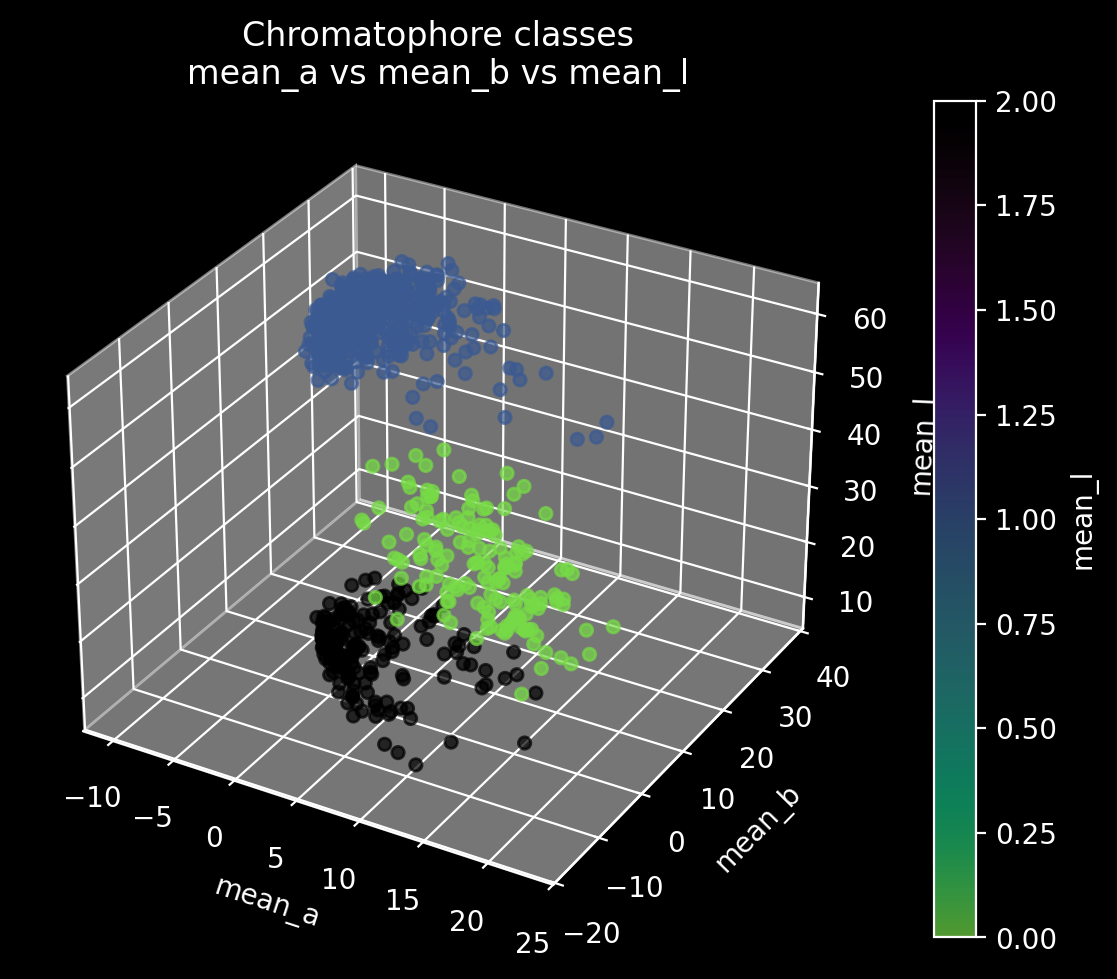

In [13]:
# Visualize per region averages and cluster identity
region_avg = chroma_data.groupby('region_id').mean(numeric_only=True)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')

# Color by cluster label
sc = ax.scatter(
    region_avg['mean_a'],
    region_avg['mean_b'],
    region_avg['mean_l'],
    c=region_avg['kmeans_label'],
    cmap='cmr.lavender_r',
    s=20,
    alpha=0.7
)

ax.set_xlabel('mean_a')
ax.set_ylabel('mean_b')
ax.set_zlabel('mean_l')
fig.colorbar(sc, ax=ax, label='mean_l')
plt.title('Chromatophore classes\nmean_a vs mean_b vs mean_l')
plt.tight_layout()
plt.show()


In [14]:
# for label in range(cluster_n):
#     pivot_label = chroma_data[chroma_data['kmeans_label'] == label].pivot_table(
#         index='region_id', columns='frame', values='area', aggfunc='mean'
#     )
#     pivot_label = pivot_label.divide(pivot_label.max(axis=1), axis=0)  # normalize

#     fig, ax = plt.subplots(figsize=(17, 3))
#     im = ax.imshow(pivot_label, aspect='auto', cmap='cmr.torch', interpolation='nearest')
#     ax.set_xlabel('Frame')
#     ax.set_ylabel('Region ID')
#     ax.set_title(f'Normalized Area Heatmap (region_id vs frame) - kmeans_label {label}')
#     fig.colorbar(im, ax=ax, label='Normalized Area')
#     plt.tight_layout()
#     plt.show()

In [15]:
from create_video import generate_label_masks_and_frames, create_mp4

### Add video and masks to napari


In [16]:
# kmeans_labels = chroma_data['kmeans_label'].dropna().unique().astype(int)
# kmeans_labels.sort()

# label_0 = []
# label_1 = []
# label_2 = []
# frames = []
# for frame_idx, frame, label_masks in generate_label_masks_and_frames(chroma_data, 
#                                                                      mask_zarr, 
#                                                                      video, 
#                                                                      kmeans_labels
#                                                                      ):
#     for label, mask in label_masks.items():
#         if label == 0:
#             label_0.append(mask)
#         elif label == 1:
#             label_1.append(mask)
#         elif label == 2:
#             label_2.append(mask)
#         else:
#             raise NotImplementedError(f'label {label} not known')
#     frames.append(frame)
# label_0 = np.stack(label_0)
# label_1 = np.stack(label_1)
# label_2 = np.stack(label_2)

In [17]:
# viewer = napari.Viewer()
# viewer.add_image(np.array(frames), name='video')
# viewer.add_labels(label_0, name='label_0')
# viewer.add_labels(label_1, name='label_1')
# viewer.add_labels(label_2, name='label_2')

### Create video from frames and chromatophore masks

In [18]:
# create_mp4(
#     chroma_data,
#     mask_zarr,
#     video,
#     export_path,
#     fps=10,
# )